# Unsupervised pre-training

*Students:* --Valentina Barletta (Deep Learning) valentina.barletta@edu.unito.it --Sara De Benedetti (Reti Neurali) sara.debenedetti493@edu.unito.it

# Autoencoder

Importing Modules

In [1]:
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import torchvision

from torchsummary import summary
from tqdm import tqdm

import os
import time

#model_path = '/content/drive/MyDrive/Progetto Deep/Data/'
#path_mount = '/content/drive/'

#from google.colab import drive
#drive.mount('/content/drive')


Get the computation device

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)                                        # Check which device we got

cpu


Prepare the Data

In [3]:
n_train = 59000
n_test = 1000

batch_size_train = 16
batch_size_test = 32

# image transformations
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize((0.1307,),(0.3081,))])

## TRAIN

dataset_train = torchvision.datasets.FashionMNIST('./files/', train=True, download=True,
                             transform=transform)

dataset_train.data, dataset_train.targets = dataset_train.data[:n_train], dataset_train.targets[:n_train]

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size = batch_size_train,
                                            shuffle = True,  drop_last = True)

## VALIDATION

dataset_Val =  torchvision.datasets.FashionMNIST('./files/', train = True, download=True,
                             transform=transform)

dataset_Val.data, dataset_Val.targets = dataset_Val.data[n_train:(n_train +n_test)], dataset_Val.targets[n_train:(n_train + n_test)]

test_loader = torch.utils.data.DataLoader(dataset_Val, batch_size = batch_size_test, shuffle = False)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./files/FashionMNIST\raw\train-images-idx3-ubyte.gz to ./files/FashionMNIST\raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./files/FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./files/FashionMNIST\raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./files/FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./files/FashionMNIST\raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./files/FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./files/FashionMNIST\raw



**Define the Convolutional Autoencoder Neural Network**

In this section, we will define our convolutional autoencoder neural network module.

An autoencoder neural network will have two parts, an encoder, and a decoder. We will be using convolutional layers.

In [4]:
input_dim = (28 * 28) # dimensione dell'input
hidden_dim = 10
out_dim = 10

class Autoencoder(nn.Module):
    def __init__(self, input_dim, out_dim):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3,3), stride=1, padding=1),  # 28 x 28 x 1 -> 28 x 28 x 8
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2, padding=0),  # 28 x 28 x 8 -> 14 x 14 x 8
                                    nn.Conv2d(8, 4, kernel_size=3, padding=1),  # 14 x 14 x 8 -> 14 x 14 x 4
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2, padding=0)) # 14 x 14 x 4 -> 7 x 7 x 4


        # Decoder
        self.decoder = nn. Sequential(nn.Conv2d(4, 4, kernel_size=3, padding=1),  # 7 x 7 x 4 -> 7 x 7 x 4
                                      nn.ReLU(),
                                      nn.Upsample(scale_factor=2, mode='nearest'),  # 7 x 7 x 4 -> 14 x 14 x 4
                                      nn.Conv2d(4, 8, kernel_size=3, padding=1),  # 14 x 14 x 4 -> 14 x 14 x 8
                                      nn.ReLU(),
                                      nn.Upsample(scale_factor=2, mode='nearest'),  # 14 x 14 x 8 -> 28 x 28 x 8
                                      nn.Conv2d(8, 1, kernel_size=3, padding=1))  # 28 x 28 x 8 -> 28 x 28 x 1


    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


model = Autoencoder(input_dim, out_dim).to(device)


In [5]:
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
              ReLU-2            [-1, 8, 28, 28]               0
         MaxPool2d-3            [-1, 8, 14, 14]               0
            Conv2d-4            [-1, 4, 14, 14]             292
              ReLU-5            [-1, 4, 14, 14]               0
         MaxPool2d-6              [-1, 4, 7, 7]               0
            Conv2d-7              [-1, 4, 7, 7]             148
              ReLU-8              [-1, 4, 7, 7]               0
          Upsample-9            [-1, 4, 14, 14]               0
           Conv2d-10            [-1, 8, 14, 14]             296
             ReLU-11            [-1, 8, 14, 14]               0
         Upsample-12            [-1, 8, 28, 28]               0
           Conv2d-13            [-1, 1, 28, 28]              73
Total params: 889
Trainable params: 889

**Loss Function and Optimizer**

For the loss function, we will use MSELoss (Mean Squared Error Loss) as we need the error between the actual pixels and the reconstructed pixels. The optimizer is going to be Adam with a learning rate of 0.001.

In [6]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

**Computing the Sparse Loss**

To compute the sparse loss, we will need the activation weights of the neural network model. This means that the sparsity gets computed after the model parameters have passed through the ReLU activation functions. Only calculating the sparsity on the model parameters will not prove to be useful.

In [7]:
# get the layers as a list
model_children = list(model.children())

We will define a `sparse_loss()` function that takes the autoencoder model and the images as input parameters. Then we will calculate the sparsity loss after the images pass through the model parameters and the ReLU activation function.

In [8]:
def sparse_loss(autoencoder, images):
    loss = 0
    values = images
    for i in range(len(model_children)):
        values = nn.ReLU()(model_children[i](values))
        loss += torch.mean(torch.abs(values))
    return loss

**The Training and Validation Functions**



Some important parameters:

*   `epochs` defines the number of epochs that we will train our autoencoder neural network for
*   `reg_param` is the regularization parameter lambda
*   `add_sparse` is a bool, either True or False. It tells whether we want to add the L1 regularization constraint or not.



In [9]:
epochs = 100
reg_param = 0.001
add_sparsity = True

Here, we will define our training and validation functions. We will call them `fit()` and `validate()` respectively.

In [19]:
def fit(model, dataloader, epoch):
    print('Training')

    model.train()
    running_loss = 0.0
    counter = 0

    for i, data in tqdm(enumerate(dataloader), total=int(len(dataset_train)/dataloader.batch_size)):
        counter += 1
        img, _ = data
        img = img.to(device)
        optimizer.zero_grad()
        outputs = model(img)
        mse_loss = criterion(outputs, img)

        if add_sparsity == True:
            l1_loss = sparse_loss(model, img)
            # add the sparsity penalty
            loss = mse_loss + reg_param * l1_loss
        else:
            loss = mse_loss
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / counter
    print(f"Train Loss: {epoch_loss:.3f}")
    return epoch_loss

In [20]:
def validate(model, dataloader, epoch):
    print('Validating')
    model.eval()
    running_loss = 0.0
    counter = 0

    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(dataset_Val)/dataloader.batch_size)):
            counter += 1
            img, _ = data
            img = img.to(device)
            outputs = model(img)
            loss = criterion(outputs, img)
            running_loss += loss.item()
    epoch_loss = running_loss / counter
    print(f"Val Loss: {loss:.3f}")

    # save the reconstructed images every 5 epochs
    if epoch % 5 == 0:
        outputs = outputs.view(outputs.size(0), 1, 28, 28).cpu().data
    return epoch_loss

**Executing the Training**

In [21]:
train_loss = []
val_loss = []
start = time.time()

for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = fit(model, train_loader, epoch)
    val_epoch_loss = validate(model, test_loader, epoch)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)

end = time.time()

print(f"{(end-start)/60:.3} minutes")


Epoch 1 of 100
Training


100%|██████████| 3687/3687 [01:45<00:00, 34.90it/s]


Train Loss: 0.113
Validating


32it [00:00, 56.68it/s]                        


Val Loss: 0.122
Epoch 2 of 100
Training


100%|██████████| 3687/3687 [01:59<00:00, 30.86it/s]


Train Loss: 0.113
Validating


32it [00:00, 47.11it/s]                        


Val Loss: 0.123
Epoch 3 of 100
Training


100%|██████████| 3687/3687 [01:59<00:00, 30.82it/s]


Train Loss: 0.113
Validating


32it [00:00, 44.51it/s]                        


Val Loss: 0.123
Epoch 4 of 100
Training


100%|██████████| 3687/3687 [02:00<00:00, 30.48it/s]


Train Loss: 0.113
Validating


32it [00:00, 47.15it/s]                        


Val Loss: 0.122
Epoch 5 of 100
Training


100%|██████████| 3687/3687 [02:00<00:00, 30.57it/s]


Train Loss: 0.113
Validating


32it [00:00, 44.05it/s]                        


Val Loss: 0.123
Epoch 6 of 100
Training


100%|██████████| 3687/3687 [02:00<00:00, 30.52it/s]


Train Loss: 0.113
Validating


32it [00:00, 41.61it/s]                        


Val Loss: 0.121
Epoch 7 of 100
Training


100%|██████████| 3687/3687 [02:00<00:00, 30.58it/s]


Train Loss: 0.113
Validating


32it [00:00, 47.04it/s]                        


Val Loss: 0.122
Epoch 8 of 100
Training


100%|██████████| 3687/3687 [01:59<00:00, 30.90it/s]


Train Loss: 0.113
Validating


32it [00:00, 45.01it/s]                        


Val Loss: 0.123
Epoch 9 of 100
Training


100%|██████████| 3687/3687 [01:59<00:00, 30.89it/s]


Train Loss: 0.113
Validating


32it [00:00, 42.77it/s]                        


Val Loss: 0.122
Epoch 10 of 100
Training


100%|██████████| 3687/3687 [01:59<00:00, 30.80it/s]


Train Loss: 0.113
Validating


32it [00:00, 46.06it/s]                        


Val Loss: 0.123
Epoch 11 of 100
Training


100%|██████████| 3687/3687 [02:00<00:00, 30.67it/s]


Train Loss: 0.113
Validating


32it [00:00, 45.04it/s]                        


Val Loss: 0.121
Epoch 12 of 100
Training


100%|██████████| 3687/3687 [02:00<00:00, 30.60it/s]


Train Loss: 0.113
Validating


32it [00:00, 46.92it/s]                        


Val Loss: 0.122
Epoch 13 of 100
Training


100%|██████████| 3687/3687 [02:00<00:00, 30.69it/s]


Train Loss: 0.113
Validating


32it [00:00, 45.06it/s]                        


Val Loss: 0.123
Epoch 14 of 100
Training


100%|██████████| 3687/3687 [01:59<00:00, 30.73it/s]


Train Loss: 0.113
Validating


32it [00:00, 45.34it/s]                        


Val Loss: 0.122
Epoch 15 of 100
Training


100%|██████████| 3687/3687 [01:59<00:00, 30.98it/s]


Train Loss: 0.113
Validating


32it [00:00, 45.10it/s]                        


Val Loss: 0.123
Epoch 16 of 100
Training


100%|██████████| 3687/3687 [01:59<00:00, 30.81it/s]


Train Loss: 0.113
Validating


32it [00:00, 45.96it/s]                        


Val Loss: 0.122
Epoch 17 of 100
Training


100%|██████████| 3687/3687 [01:59<00:00, 30.80it/s]


Train Loss: 0.112
Validating


32it [00:00, 45.77it/s]                        


Val Loss: 0.122
Epoch 18 of 100
Training


100%|██████████| 3687/3687 [02:00<00:00, 30.55it/s]


Train Loss: 0.112
Validating


32it [00:00, 45.87it/s]                        


Val Loss: 0.121
Epoch 19 of 100
Training


100%|██████████| 3687/3687 [02:00<00:00, 30.69it/s]


Train Loss: 0.112
Validating


32it [00:00, 46.20it/s]                        


Val Loss: 0.120
Epoch 20 of 100
Training


100%|██████████| 3687/3687 [02:02<00:00, 30.11it/s]


Train Loss: 0.112
Validating


32it [00:00, 45.19it/s]                        


Val Loss: 0.120
Epoch 21 of 100
Training


100%|██████████| 3687/3687 [01:59<00:00, 30.82it/s]


Train Loss: 0.112
Validating


32it [00:00, 43.46it/s]                        


Val Loss: 0.120
Epoch 22 of 100
Training


100%|██████████| 3687/3687 [01:59<00:00, 30.74it/s]


Train Loss: 0.112
Validating


32it [00:00, 44.75it/s]                        


Val Loss: 0.121
Epoch 23 of 100
Training


100%|██████████| 3687/3687 [01:39<00:00, 36.92it/s]


Train Loss: 0.112
Validating


32it [00:00, 70.43it/s]                        


Val Loss: 0.122
Epoch 24 of 100
Training


100%|██████████| 3687/3687 [01:21<00:00, 45.38it/s]


Train Loss: 0.112
Validating


32it [00:00, 45.39it/s]                        


Val Loss: 0.120
Epoch 25 of 100
Training


100%|██████████| 3687/3687 [01:25<00:00, 43.30it/s]


Train Loss: 0.112
Validating


32it [00:00, 61.42it/s]                        


Val Loss: 0.118
Epoch 26 of 100
Training


100%|██████████| 3687/3687 [01:28<00:00, 41.71it/s]


Train Loss: 0.112
Validating


32it [00:00, 56.30it/s]                        


Val Loss: 0.119
Epoch 27 of 100
Training


100%|██████████| 3687/3687 [01:27<00:00, 42.31it/s]


Train Loss: 0.112
Validating


32it [00:00, 65.80it/s]                        


Val Loss: 0.120
Epoch 28 of 100
Training


100%|██████████| 3687/3687 [01:27<00:00, 41.90it/s]


Train Loss: 0.112
Validating


32it [00:00, 69.54it/s]                        


Val Loss: 0.118
Epoch 29 of 100
Training


100%|██████████| 3687/3687 [01:33<00:00, 39.40it/s]


Train Loss: 0.112
Validating


32it [00:00, 53.70it/s]                        


Val Loss: 0.120
Epoch 30 of 100
Training


100%|██████████| 3687/3687 [01:32<00:00, 39.69it/s]


Train Loss: 0.112
Validating


32it [00:00, 66.71it/s]                        


Val Loss: 0.119
Epoch 31 of 100
Training


100%|██████████| 3687/3687 [01:30<00:00, 40.61it/s]


Train Loss: 0.112
Validating


32it [00:00, 69.54it/s]                        


Val Loss: 0.119
Epoch 32 of 100
Training


100%|██████████| 3687/3687 [01:35<00:00, 38.66it/s]


Train Loss: 0.112
Validating


32it [00:00, 60.38it/s]                        


Val Loss: 0.120
Epoch 33 of 100
Training


100%|██████████| 3687/3687 [01:36<00:00, 38.13it/s]


Train Loss: 0.112
Validating


32it [00:00, 62.58it/s]                        


Val Loss: 0.118
Epoch 34 of 100
Training


100%|██████████| 3687/3687 [01:31<00:00, 40.42it/s]


Train Loss: 0.112
Validating


32it [00:00, 66.37it/s]                        


Val Loss: 0.120
Epoch 35 of 100
Training


100%|██████████| 3687/3687 [01:32<00:00, 39.72it/s]


Train Loss: 0.112
Validating


32it [00:00, 41.79it/s]                        


Val Loss: 0.118
Epoch 36 of 100
Training


100%|██████████| 3687/3687 [02:01<00:00, 30.24it/s]


Train Loss: 0.112
Validating


32it [00:00, 46.38it/s]                        


Val Loss: 0.119
Epoch 37 of 100
Training


100%|██████████| 3687/3687 [02:01<00:00, 30.30it/s]


Train Loss: 0.112
Validating


32it [00:00, 43.90it/s]                        


Val Loss: 0.121
Epoch 38 of 100
Training


100%|██████████| 3687/3687 [02:08<00:00, 28.60it/s]


Train Loss: 0.112
Validating


32it [00:00, 47.47it/s]                        


Val Loss: 0.119
Epoch 39 of 100
Training


100%|██████████| 3687/3687 [02:05<00:00, 29.27it/s]


Train Loss: 0.112
Validating


32it [00:00, 47.08it/s]                        


Val Loss: 0.119
Epoch 40 of 100
Training


100%|██████████| 3687/3687 [02:03<00:00, 29.93it/s]


Train Loss: 0.112
Validating


32it [00:00, 45.21it/s]                        


Val Loss: 0.119
Epoch 41 of 100
Training


100%|██████████| 3687/3687 [02:05<00:00, 29.46it/s]


Train Loss: 0.112
Validating


32it [00:00, 42.92it/s]                        


Val Loss: 0.120
Epoch 42 of 100
Training


100%|██████████| 3687/3687 [02:03<00:00, 29.88it/s]


Train Loss: 0.112
Validating


32it [00:00, 45.30it/s]                        


Val Loss: 0.119
Epoch 43 of 100
Training


100%|██████████| 3687/3687 [02:05<00:00, 29.49it/s]


Train Loss: 0.112
Validating


32it [00:00, 45.13it/s]                        


Val Loss: 0.119
Epoch 44 of 100
Training


100%|██████████| 3687/3687 [02:04<00:00, 29.64it/s]


Train Loss: 0.112
Validating


32it [00:00, 45.08it/s]                        


Val Loss: 0.119
Epoch 45 of 100
Training


100%|██████████| 3687/3687 [02:07<00:00, 28.91it/s]


Train Loss: 0.112
Validating


32it [00:00, 45.60it/s]                        


Val Loss: 0.121
Epoch 46 of 100
Training


100%|██████████| 3687/3687 [02:01<00:00, 30.27it/s]


Train Loss: 0.112
Validating


32it [00:00, 43.18it/s]                        


Val Loss: 0.119
Epoch 47 of 100
Training


100%|██████████| 3687/3687 [02:02<00:00, 30.05it/s]


Train Loss: 0.112
Validating


32it [00:00, 46.22it/s]                        


Val Loss: 0.119
Epoch 48 of 100
Training


100%|██████████| 3687/3687 [02:03<00:00, 29.75it/s]


Train Loss: 0.112
Validating


32it [00:00, 47.40it/s]                        


Val Loss: 0.121
Epoch 49 of 100
Training


100%|██████████| 3687/3687 [02:10<00:00, 28.26it/s]


Train Loss: 0.112
Validating


32it [00:00, 41.64it/s]                        


Val Loss: 0.118
Epoch 50 of 100
Training


100%|██████████| 3687/3687 [02:08<00:00, 28.70it/s]


Train Loss: 0.112
Validating


32it [00:00, 43.15it/s]                        


Val Loss: 0.120
Epoch 51 of 100
Training


100%|██████████| 3687/3687 [02:21<00:00, 26.04it/s]


Train Loss: 0.112
Validating


32it [00:00, 38.95it/s]                        


Val Loss: 0.119
Epoch 52 of 100
Training


100%|██████████| 3687/3687 [02:43<00:00, 22.55it/s]


Train Loss: 0.112
Validating


32it [00:00, 35.25it/s]                        


Val Loss: 0.120
Epoch 53 of 100
Training


100%|██████████| 3687/3687 [02:19<00:00, 26.43it/s]


Train Loss: 0.112
Validating


32it [00:00, 55.22it/s]                        


Val Loss: 0.122
Epoch 54 of 100
Training


100%|██████████| 3687/3687 [02:05<00:00, 29.37it/s]


Train Loss: 0.112
Validating


32it [00:00, 55.30it/s]                        


Val Loss: 0.119
Epoch 55 of 100
Training


100%|██████████| 3687/3687 [02:00<00:00, 30.64it/s]


Train Loss: 0.112
Validating


32it [00:00, 53.75it/s]                        


Val Loss: 0.119
Epoch 56 of 100
Training


100%|██████████| 3687/3687 [02:00<00:00, 30.62it/s]


Train Loss: 0.112
Validating


32it [00:00, 55.18it/s]                        


Val Loss: 0.119
Epoch 57 of 100
Training


100%|██████████| 3687/3687 [02:07<00:00, 28.96it/s]


Train Loss: 0.112
Validating


32it [00:00, 56.82it/s]                        


Val Loss: 0.120
Epoch 58 of 100
Training


100%|██████████| 3687/3687 [02:06<00:00, 29.23it/s]


Train Loss: 0.112
Validating


32it [00:00, 58.44it/s]                        


Val Loss: 0.120
Epoch 59 of 100
Training


100%|██████████| 3687/3687 [02:01<00:00, 30.35it/s]


Train Loss: 0.112
Validating


32it [00:00, 58.34it/s]                        


Val Loss: 0.120
Epoch 60 of 100
Training


100%|██████████| 3687/3687 [02:02<00:00, 29.99it/s]


Train Loss: 0.112
Validating


32it [00:00, 34.49it/s]                        


Val Loss: 0.120
Epoch 61 of 100
Training


100%|██████████| 3687/3687 [01:59<00:00, 30.81it/s]


Train Loss: 0.112
Validating


32it [00:00, 53.73it/s]                        


Val Loss: 0.121
Epoch 62 of 100
Training


100%|██████████| 3687/3687 [02:00<00:00, 30.59it/s]


Train Loss: 0.112
Validating


32it [00:00, 59.25it/s]                        


Val Loss: 0.120
Epoch 63 of 100
Training


100%|██████████| 3687/3687 [01:58<00:00, 31.22it/s]


Train Loss: 0.112
Validating


32it [00:00, 56.71it/s]                        


Val Loss: 0.122
Epoch 64 of 100
Training


100%|██████████| 3687/3687 [02:00<00:00, 30.48it/s]


Train Loss: 0.112
Validating


32it [00:00, 61.95it/s]                        


Val Loss: 0.120
Epoch 65 of 100
Training


100%|██████████| 3687/3687 [01:55<00:00, 32.01it/s]


Train Loss: 0.112
Validating


32it [00:00, 56.77it/s]                        


Val Loss: 0.120
Epoch 66 of 100
Training


100%|██████████| 3687/3687 [01:54<00:00, 32.26it/s]


Train Loss: 0.112
Validating


32it [00:00, 55.24it/s]                        


Val Loss: 0.119
Epoch 67 of 100
Training


100%|██████████| 3687/3687 [01:54<00:00, 32.34it/s]


Train Loss: 0.112
Validating


32it [00:00, 60.02it/s]                        


Val Loss: 0.121
Epoch 68 of 100
Training


100%|██████████| 3687/3687 [01:52<00:00, 32.86it/s]


Train Loss: 0.112
Validating


32it [00:00, 58.36it/s]                        


Val Loss: 0.119
Epoch 69 of 100
Training


100%|██████████| 3687/3687 [01:51<00:00, 32.93it/s]


Train Loss: 0.112
Validating


32it [00:00, 58.35it/s]                        


Val Loss: 0.120
Epoch 70 of 100
Training


100%|██████████| 3687/3687 [01:52<00:00, 32.75it/s]


Train Loss: 0.112
Validating


32it [00:00, 58.21it/s]                        


Val Loss: 0.121
Epoch 71 of 100
Training


100%|██████████| 3687/3687 [01:52<00:00, 32.69it/s]


Train Loss: 0.112
Validating


32it [00:00, 55.38it/s]                        


Val Loss: 0.121
Epoch 72 of 100
Training


100%|██████████| 3687/3687 [01:54<00:00, 32.22it/s]


Train Loss: 0.112
Validating


32it [00:00, 56.72it/s]                        


Val Loss: 0.119
Epoch 73 of 100
Training


100%|██████████| 3687/3687 [01:53<00:00, 32.37it/s]


Train Loss: 0.112
Validating


32it [00:00, 56.72it/s]                        


Val Loss: 0.123
Epoch 74 of 100
Training


100%|██████████| 3687/3687 [01:55<00:00, 31.82it/s]


Train Loss: 0.112
Validating


32it [00:00, 58.45it/s]                        


Val Loss: 0.120
Epoch 75 of 100
Training


100%|██████████| 3687/3687 [01:54<00:00, 32.11it/s]


Train Loss: 0.112
Validating


32it [00:00, 58.79it/s]                        


Val Loss: 0.120
Epoch 76 of 100
Training


100%|██████████| 3687/3687 [01:55<00:00, 31.95it/s]


Train Loss: 0.112
Validating


32it [00:00, 39.21it/s]                        


Val Loss: 0.120
Epoch 77 of 100
Training


100%|██████████| 3687/3687 [01:53<00:00, 32.38it/s]


Train Loss: 0.112
Validating


32it [00:00, 58.47it/s]                        


Val Loss: 0.119
Epoch 78 of 100
Training


100%|██████████| 3687/3687 [01:52<00:00, 32.65it/s]


Train Loss: 0.112
Validating


32it [00:00, 56.80it/s]                        


Val Loss: 0.120
Epoch 79 of 100
Training


100%|██████████| 3687/3687 [01:53<00:00, 32.48it/s]


Train Loss: 0.112
Validating


32it [00:00, 56.84it/s]                        


Val Loss: 0.120
Epoch 80 of 100
Training


100%|██████████| 3687/3687 [01:55<00:00, 32.03it/s]


Train Loss: 0.112
Validating


32it [00:00, 57.19it/s]                        


Val Loss: 0.123
Epoch 81 of 100
Training


100%|██████████| 3687/3687 [01:53<00:00, 32.40it/s]


Train Loss: 0.112
Validating


32it [00:00, 55.20it/s]                        


Val Loss: 0.120
Epoch 82 of 100
Training


100%|██████████| 3687/3687 [01:58<00:00, 31.10it/s]


Train Loss: 0.112
Validating


32it [00:00, 58.41it/s]                        


Val Loss: 0.118
Epoch 83 of 100
Training


100%|██████████| 3687/3687 [01:53<00:00, 32.45it/s]


Train Loss: 0.112
Validating


32it [00:00, 58.41it/s]                        


Val Loss: 0.120
Epoch 84 of 100
Training


100%|██████████| 3687/3687 [01:52<00:00, 32.67it/s]


Train Loss: 0.112
Validating


32it [00:00, 57.95it/s]                        


Val Loss: 0.119
Epoch 85 of 100
Training


100%|██████████| 3687/3687 [01:54<00:00, 32.21it/s]


Train Loss: 0.112
Validating


32it [00:00, 57.02it/s]                        


Val Loss: 0.120
Epoch 86 of 100
Training


100%|██████████| 3687/3687 [01:56<00:00, 31.76it/s]


Train Loss: 0.112
Validating


32it [00:00, 56.84it/s]                        


Val Loss: 0.121
Epoch 87 of 100
Training


100%|██████████| 3687/3687 [01:55<00:00, 31.88it/s]


Train Loss: 0.112
Validating


32it [00:00, 56.69it/s]                        


Val Loss: 0.119
Epoch 88 of 100
Training


100%|██████████| 3687/3687 [01:54<00:00, 32.08it/s]


Train Loss: 0.112
Validating


32it [00:00, 56.82it/s]                        


Val Loss: 0.120
Epoch 89 of 100
Training


100%|██████████| 3687/3687 [01:53<00:00, 32.44it/s]


Train Loss: 0.112
Validating


32it [00:00, 60.09it/s]                        


Val Loss: 0.119
Epoch 90 of 100
Training


100%|██████████| 3687/3687 [01:55<00:00, 31.86it/s]


Train Loss: 0.112
Validating


32it [00:00, 58.20it/s]                        


Val Loss: 0.120
Epoch 91 of 100
Training


100%|██████████| 3687/3687 [01:57<00:00, 31.29it/s]


Train Loss: 0.112
Validating


32it [00:00, 57.24it/s]                        


Val Loss: 0.119
Epoch 92 of 100
Training


100%|██████████| 3687/3687 [01:59<00:00, 30.89it/s]


Train Loss: 0.112
Validating


32it [00:00, 56.69it/s]                        


Val Loss: 0.119
Epoch 93 of 100
Training


100%|██████████| 3687/3687 [01:57<00:00, 31.33it/s]


Train Loss: 0.112
Validating


32it [00:00, 58.40it/s]                        


Val Loss: 0.119
Epoch 94 of 100
Training


100%|██████████| 3687/3687 [02:17<00:00, 26.83it/s]


Train Loss: 0.112
Validating


32it [00:00, 55.10it/s]                        


Val Loss: 0.119
Epoch 95 of 100
Training


100%|██████████| 3687/3687 [02:00<00:00, 30.65it/s]


Train Loss: 0.112
Validating


32it [00:00, 60.16it/s]                        


Val Loss: 0.117
Epoch 96 of 100
Training


100%|██████████| 3687/3687 [01:57<00:00, 31.35it/s]


Train Loss: 0.112
Validating


32it [00:00, 58.46it/s]                        


Val Loss: 0.117
Epoch 97 of 100
Training


100%|██████████| 3687/3687 [02:02<00:00, 30.18it/s]


Train Loss: 0.112
Validating


32it [00:00, 58.40it/s]                        


Val Loss: 0.118
Epoch 98 of 100
Training


100%|██████████| 3687/3687 [01:58<00:00, 31.22it/s]


Train Loss: 0.112
Validating


32it [00:00, 60.19it/s]                        


Val Loss: 0.119
Epoch 99 of 100
Training


100%|██████████| 3687/3687 [01:58<00:00, 31.04it/s]


Train Loss: 0.112
Validating


32it [00:00, 58.47it/s]                        


Val Loss: 0.118
Epoch 100 of 100
Training


100%|██████████| 3687/3687 [01:59<00:00, 30.79it/s]


Train Loss: 0.112
Validating


32it [00:00, 60.20it/s]                        

Val Loss: 0.119
1.95e+02 minutes


In [22]:
train_loss

[0.11302625803579507,
 0.11299396306276321,
 0.11294958947601763,
 0.11281923994175425,
 0.11284672504062086,
 0.11280742653193175,
 0.11274064700431154,
 0.11269256245857143,
 0.11268430335155696,
 0.1126947893071763,
 0.11264548666122517,
 0.11261634938449176,
 0.11257250266311807,
 0.11252404410510261,
 0.1125297043235088,
 0.11252399353532246,
 0.11246649698453574,
 0.11243129649321044,
 0.11240416181816588,
 0.11236520783264914,
 0.11234676527530804,
 0.11228852626719318,
 0.1123105153170646,
 0.11221322935182679,
 0.11219294038016459,
 0.11216919675392609,
 0.11210536916775855,
 0.11210684127073027,
 0.11209738466728014,
 0.1121318213073807,
 0.11204705123239202,
 0.1120056805226387,
 0.11201667851117493,
 0.1120016383896813,
 0.11202116137012286,
 0.11194172782046963,
 0.11194281764217337,
 0.11197138348544294,
 0.11196513158343237,
 0.11192179789929846,
 0.1119033200694094,
 0.11190346692283851,
 0.11187169015617722,
 0.11190009942004957,
 0.11190444473121623,
 0.11183177817593

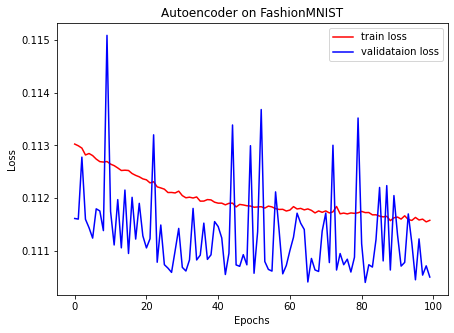

In [28]:
# loss plots
plt.figure(figsize=(7, 5))
plt.plot(train_loss, color='red', label='train loss')
plt.plot(val_loss, color='blue', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.title("Autoencoder on FashionMNIST")

plt.show()

<Figure size 1500x1000 with 0 Axes>

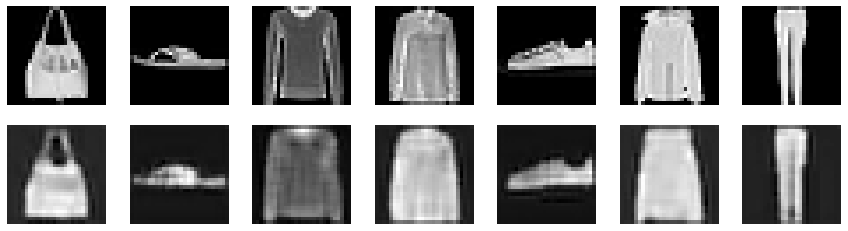

In [26]:
with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)
        recon = model(data)
        break

import matplotlib.pyplot as plt
plt.figure(dpi=250)
fig, ax = plt.subplots(2, 7, figsize=(15, 4))
for i in range(7):
    ax[0, i].imshow(data[i].cpu().numpy().squeeze(), cmap='gray')
    ax[1, i].imshow(recon[i].cpu().numpy().squeeze(), cmap='gray')
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
plt.show()


Save the model

In [15]:
file_name = 'FashionMNIST_sparse.pth'
torch.save(model.state_dict(), file_name)